In [11]:
begin
    using Pkg
    dev_folder = "../Examples/"
    Pkg.activate(dev_folder)
end

## Uncomment the following lines for the first run, to add the package to the environment
# begin
#      pkg_folder = "../" # folder of the package # folder of the development environment
#      Pkg.develop(path=pkg_folder) # run only once, tell julia to develop the package
#      Pkg.instantiate()
# end

Threads.nthreads() 

using Revise
using BindingAndCatalysis # import the package
using CairoMakie # for plotting

  Activating project at `~/Realizibility_index/BindingAndCatalysis.jl/Examples`


In [2]:
# #binding
model = let
    N = [1 1 -1]  # define stoichiometry matrix
    x_sym = [:E, :S, :C] # Optional: define species symbols
    q_sym = [:tE, :tS] # Optional: define total concentration symbols
    K_sym = [:K] # Optional: define binding constant symbols
    Bnc(N = N, x_sym=x_sym, q_sym=q_sym, K_sym=K_sym) # create Bnc model
end
find_all_vertices!(model)
summary(model)

---------------------Start finding all vertices, it may takes a while.--------------------
Finished, with 4 vertices found and 4 asymptotic vertices.

-------------Start calculating nullity for each vertex, it also takes a while.------------
1.Building Nρ_inv cache in parallel...
2.Calculating nullity for each vertex in parallel...
3.Storing all vertices information...
Done.
----------Binding Network Summary:-------------
Number of species (n): 3
Number of conserved quantities (d): 2
Number of reactions (r): 1
L matrix: [1 0 1; 0 1 1]
N matrix: [1 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 4
  - Invertible + Asymptotic: 3
  - Singular +  Asymptotic: 1
  - Invertible +  Non-Asymptotic: 0
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


In [3]:
logK=0
logE_rg = (-6,6)
logS_rg = (-6,6)
total_points = 1e6 # points each dimension
pts_each_dim =round(Int, total_points^(1/2))

1000

logx_directly solve

In [ ]:
data = let 
    logK=0
    logE_rg = (-6,6)
    logS_rg = (-6,6)
    # total_points = 1e6 # points each dimension
    pts_each_dim =1000

    data = Matrix{Vector{Float64}}(undef, pts_each_dim, pts_each_dim)
    
    # fill the first axis
    startqK = [logE_rg[1], logS_rg[1],  logK] # in tE,tS, K order
    endqK = [logE_rg[1], logS_rg[2],logK]
    data[:,1] .= x_traj_with_qK_change(model,startqK,endqK; 
        input_logspace=true, output_logspace=true,npoints=pts_each_dim)[2]

    # fill the second axis
    start_logS = range(logS_rg..., length=pts_each_dim)
    Threads.@threads for i in 1:pts_each_dim
        startqK = [logE_rg[1], start_logS[i],  logK] 
        endqK = [logE_rg[2], start_logS[i], logK]
        # start_logx = data[i,1]
        data[i,1:end] .= x_traj_with_qK_change(model, startqK, endqK; 
            # startlogx = start_logx, 
            input_logspace=true, output_logspace=true,npoints=pts_each_dim)[2]
    end
    data
end

# # log x using regimes
# logx_rgm = let
#     data = Matrix{Vector{Float64}}(undef, pts_each_dim,pts_each_dim)
#     lgS = range(logS_rg..., length=pts_each_dim)
#     lgE = range(logE_rg..., length=pts_each_dim)
#     Threads.@threads for i in 1:pts_each_dim
#         for j in 1:pts_each_dim
#             logqK = [lgS[i], lgE[j], logK]
#             data[i,j] = qK2x(model, logqK;input_logspace=true,output_logspace=true, use_vtx=true)
#         end
#     end
#     data
# end

MM_C(Et,St,K) = Et*St/(St+K)
logC_MM = log10.(
    MM_C.(
        exp10.(range(logS_rg...,pts_each_dim)),
        exp10.(range(logE_rg...,pts_each_dim)')
        ,1)
    )

1000×1000 Matrix{Float64}:
 -12.0         -11.988       -11.976       …  -6.0      -6.0      -6.0
 -11.988       -11.976       -11.964          -5.98799  -5.98799  -5.98799
 -11.976       -11.964       -11.952          -5.97598  -5.97598  -5.97598
 -11.964       -11.952       -11.9399         -5.96396  -5.96396  -5.96396
 -11.952       -11.9399      -11.9279         -5.95195  -5.95195  -5.95195
 -11.9399      -11.9279      -11.9159      …  -5.93994  -5.93994  -5.93994
 -11.9279      -11.9159      -11.9039         -5.92793  -5.92793  -5.92793
 -11.9159      -11.9039      -11.8919         -5.91592  -5.91592  -5.91592
 -11.9039      -11.8919      -11.8799         -5.9039   -5.9039   -5.9039
 -11.8919      -11.8799      -11.8679         -5.89189  -5.89189  -5.89189
 -11.8799      -11.8679      -11.8559      …  -5.87988  -5.87988  -5.87988
 -11.8679      -11.8559      -11.8438         -5.86787  -5.86787  -5.86787
 -11.8559      -11.8438      -11.8318         -5.85586  -5.85586  -5.85586
   

Data michealis-menten

In [40]:
logx_rgm = let
    data = Matrix{Vector{Float64}}(undef, pts_each_dim,pts_each_dim)
    lgS = range(logS_rg..., length=pts_each_dim)
    lgE = range(logE_rg..., length=pts_each_dim)
    Threads.@threads for i in 1:pts_each_dim
        for j in 1:pts_each_dim
            logqK = [lgS[i], lgE[j], logK]
            data[i,j] = qK2x(model, logqK;input_logspace=true,output_logspace=true, use_vtx=true)
        end
    end
    data
end

1000×1000 Matrix{Vector{Float64}}:
 [-6.0, -6.0, -12.0]         …  [-12.0, 6.0, -6.0]
 [-5.98799, -6.0, -11.988]      [-11.988, 6.0, -5.98799]
 [-5.97598, -6.0, -11.976]      [-11.976, 6.0, -5.97598]
 [-5.96396, -6.0, -11.964]      [-11.964, 6.0, -5.96396]
 [-5.95195, -6.0, -11.952]      [-11.952, 6.0, -5.95195]
 [-5.93994, -6.0, -11.9399]  …  [-11.9399, 6.0, -5.93994]
 [-5.92793, -6.0, -11.9279]     [-11.9279, 6.0, -5.92793]
 [-5.91592, -6.0, -11.9159]     [-11.9159, 6.0, -5.91592]
 [-5.9039, -6.0, -11.9039]      [-11.9039, 6.0, -5.9039]
 [-5.89189, -6.0, -11.8919]     [-11.8919, 6.0, -5.89189]
 [-5.87988, -6.0, -11.8799]  …  [-11.8799, 6.0, -5.87988]
 [-5.86787, -6.0, -11.8679]     [-11.8679, 6.0, -5.86787]
 [-5.85586, -6.0, -11.8559]     [-11.8559, 6.0, -5.85586]
 ⋮                           ⋱  
 [5.86787, -11.8679, -6.0]      [-0.132132, 6.0, 5.86787]
 [5.87988, -11.8799, -6.0]      [-0.12012, 6.0, 5.87988]
 [5.89189, -11.8919, -6.0]   …  [-0.108108, 6.0, 5.89189]
 [5.9039, -11.903

In [15]:
col_asym_x = logx .|> x->assign_vertex_x(model, x,input_logspace=true; asymptotic_only=true,return_idx=true)
col_nonasym_x = logx .|> x->assign_vertex_x(model, x,input_logspace=true; asymptotic_only=false,return_idx=true)
col_asym_qK = logx .|> x->assign_vertex_qK(model; x=x,input_logspace=true , asymptotic_only=true,return_idx=true) 
col_nonasym_qK = logx .|> x->assign_vertex_qK(model; x=x,input_logspace=true , asymptotic_only=false,return_idx=true)

bnds_asym_x = find_bounds(col_asym_x)
bnds_nonasym_x = find_bounds(col_nonasym_x)
bnds_asym_qK = find_bounds(col_asym_qK)
bnds_nonasym_qK = find_bounds(col_nonasym_qK)
print("Done")

Done

In [6]:
unique_rgm = sort!(unique(col_nonasym_x))
col_map_dict, cmap_disc = get_color_map(unique_rgm)

(Dict(4 => 4, 2 => 2, 3 => 3, 1 => 1), PlotUtils.CategoricalColorGradient(ColorSchemes.ColorScheme{Vector{ColorTypes.RGBA{Float64}}, String, String}(ColorTypes.RGBA{Float64}[RGBA(0.5019607843137255, 0.0, 0.5019607843137255, 1.0), RGBA(0.0, 0.16732026143790835, 0.666666666666667, 1.0), RGBA(0.6666666666666665, 0.5986928104575163, 0.0, 1.0), RGBA(1.0, 0.0, 0.0, 1.0)], "", ""), [0.0, 0.25, 0.5, 0.75, 1.0]))

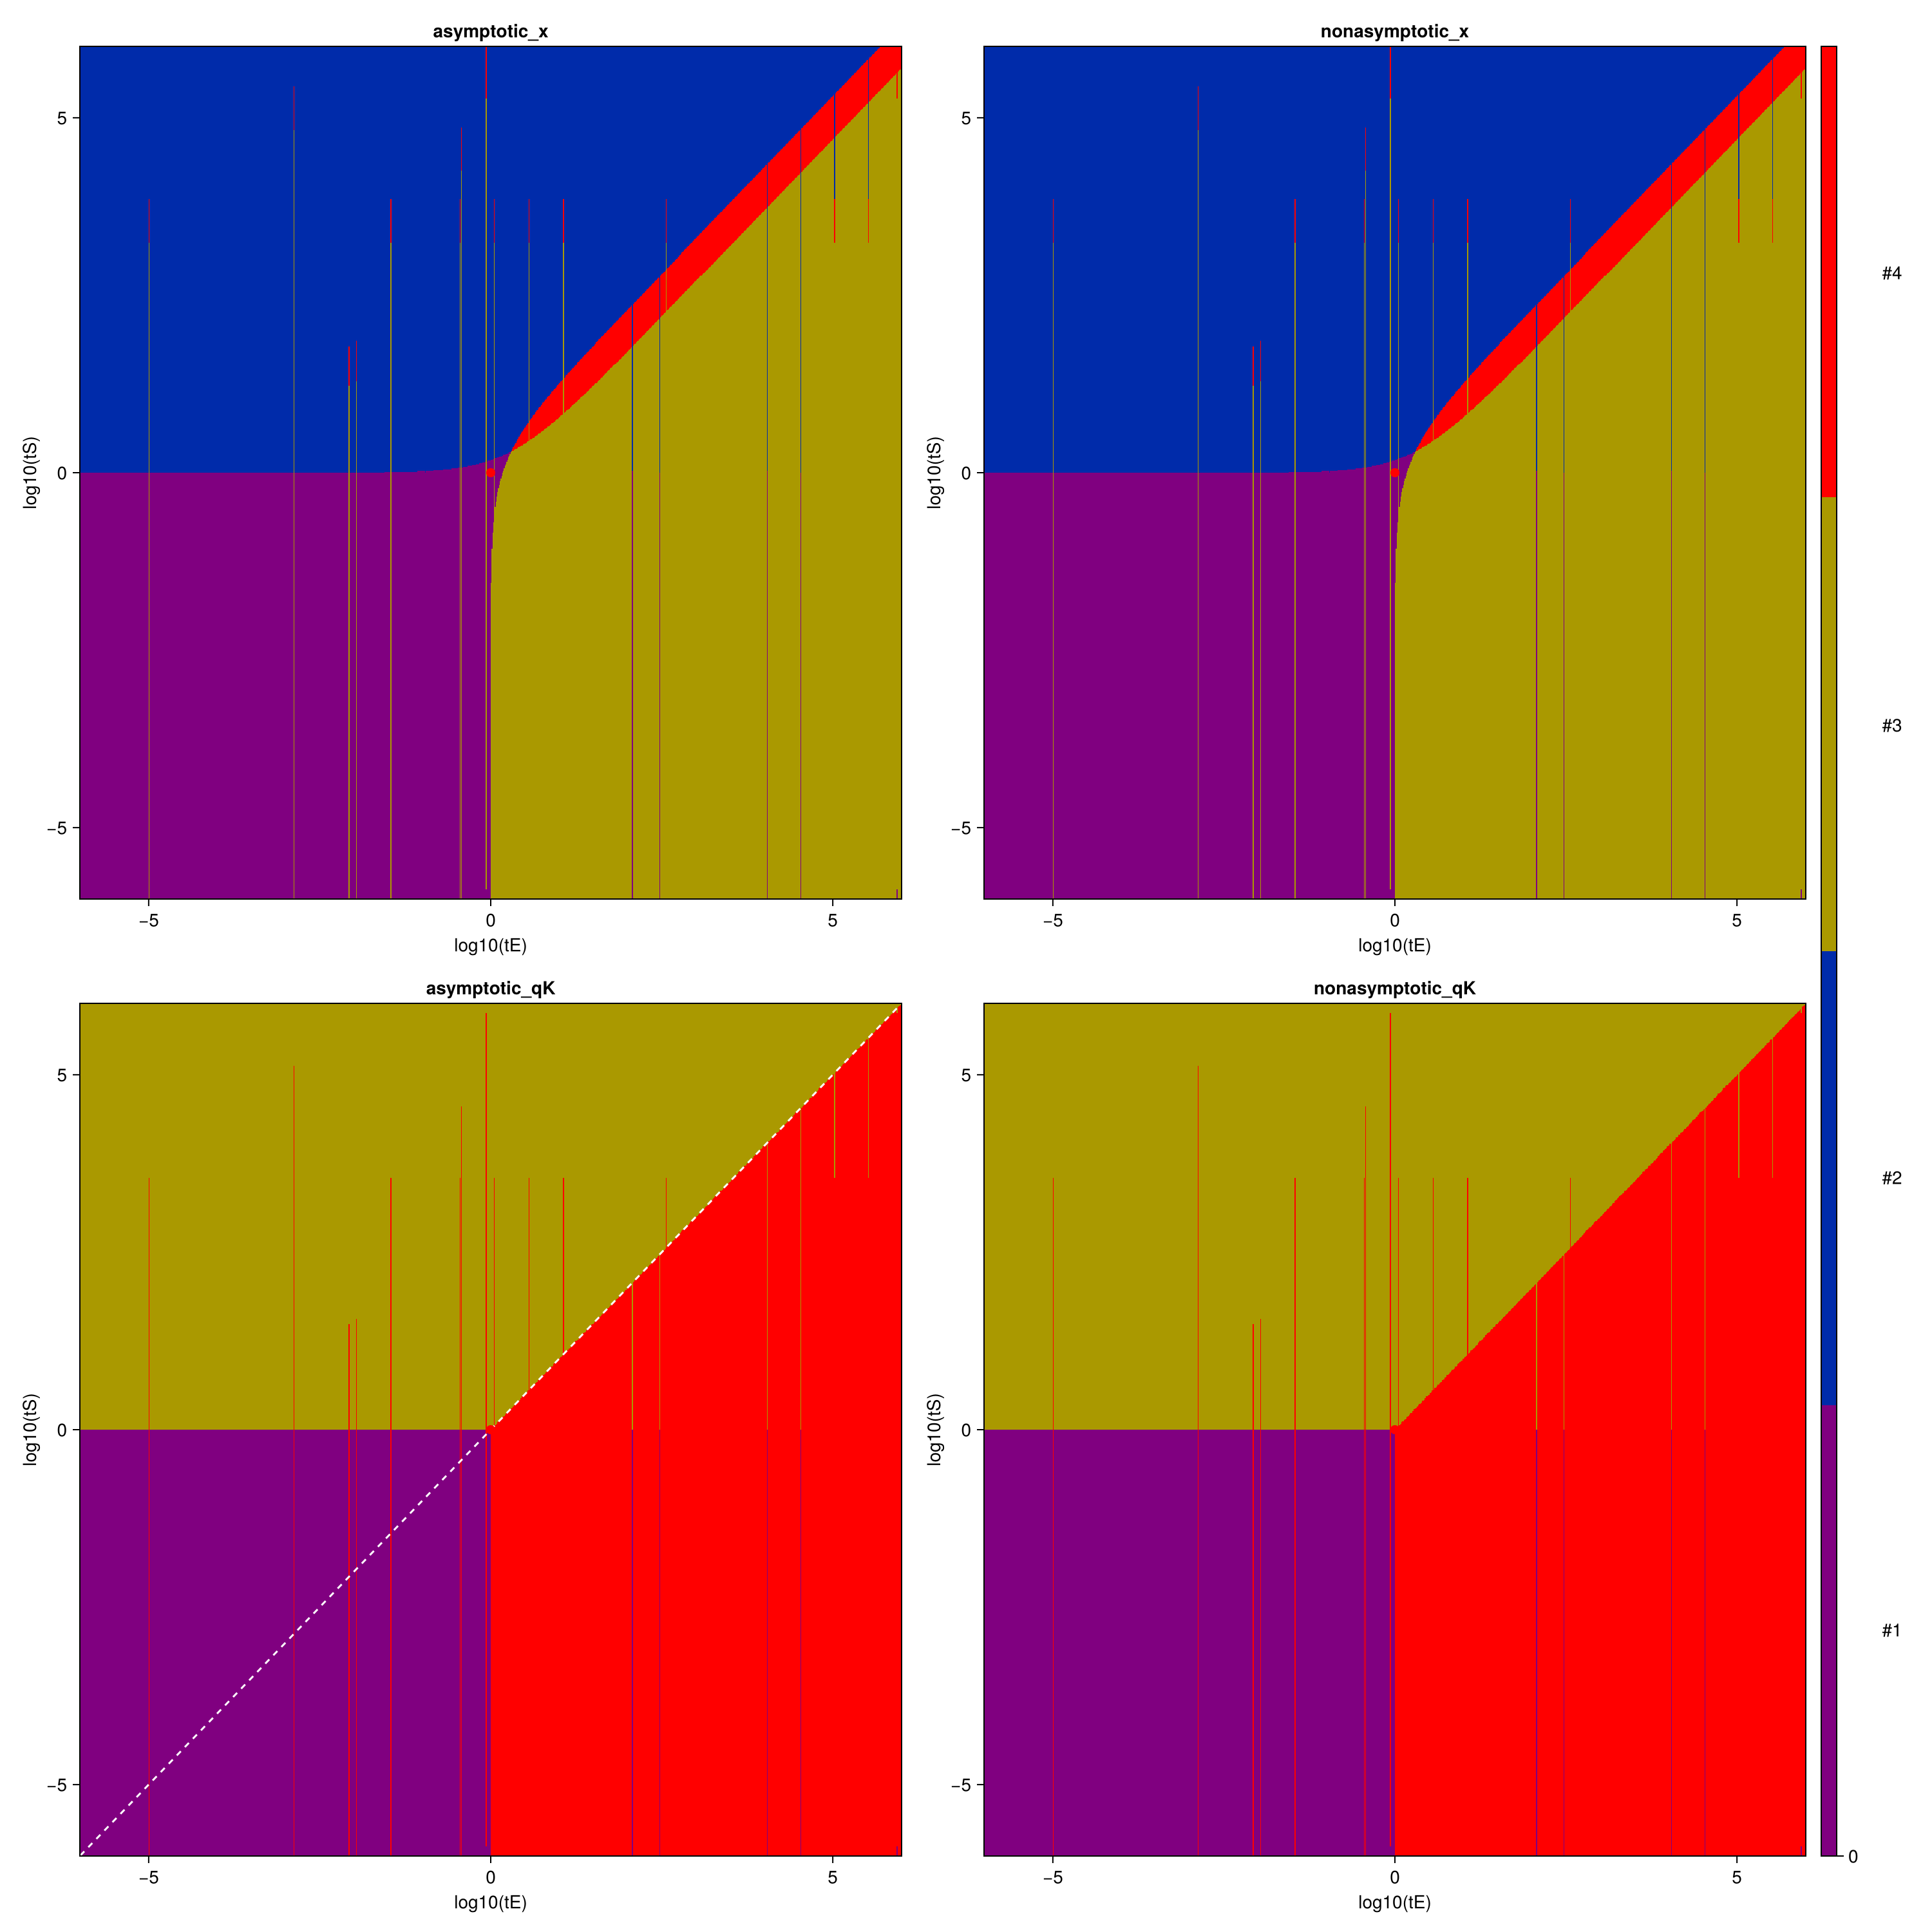

CairoMakie.Screen{IMAGE}


In [20]:

# using GLMakie

f = Figure(size=(1500,1500))
p1 = Axis(f[1, 1])
p2 = Axis(f[1, 2])
p3 = Axis(f[2, 1])
p4 = Axis(f[2, 2])

# --- Plot 1: asymptotic_x ---
p1.title = "asymptotic_x"
heatmap!(p1, logE_rg, logS_rg, getindex.(Ref(col_map_dict), col_asym_x), colormap=cmap_disc)
# contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)
# --- Plot 2: nonasymptotic_x ---
p2.title = "nonasymptotic_x"
heatmap!(p2, logE_rg, logS_rg, getindex.(Ref(col_map_dict), col_nonasym_x), colormap=cmap_disc)
# --- Plot 3: asymptotic_qK ---
p3.title = "asymptotic_qK"
heatmap!(p3, logE_rg, logS_rg, getindex.(Ref(col_map_dict), col_asym_qK), colormap=cmap_disc)
# contour!(p3, logE_rg, logS_rg, bnds_nonasym_x, color = :black)
lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)

# --- Plot 4: nonasymptotic_qK ---
p4.title = "nonasymptotic_qK"
heatmap!(p4, logE_rg, logS_rg, getindex.(Ref(col_map_dict), col_nonasym_qK), colormap=cmap_disc)
# contour!(p4, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

for p in [p1, p2, p3, p4]
    # Add the red dot
    scatter!(p, [logK], [logK], marker=:circle, markersize=10, color=:red)
    # Set the axis labels (modern syntax)
    p.xlabel = "log10(tE)"
    p.ylabel = "log10(tS)"
end

add_rgm_label!(f,unique_rgm,colormap=cmap_disc)

display(f)

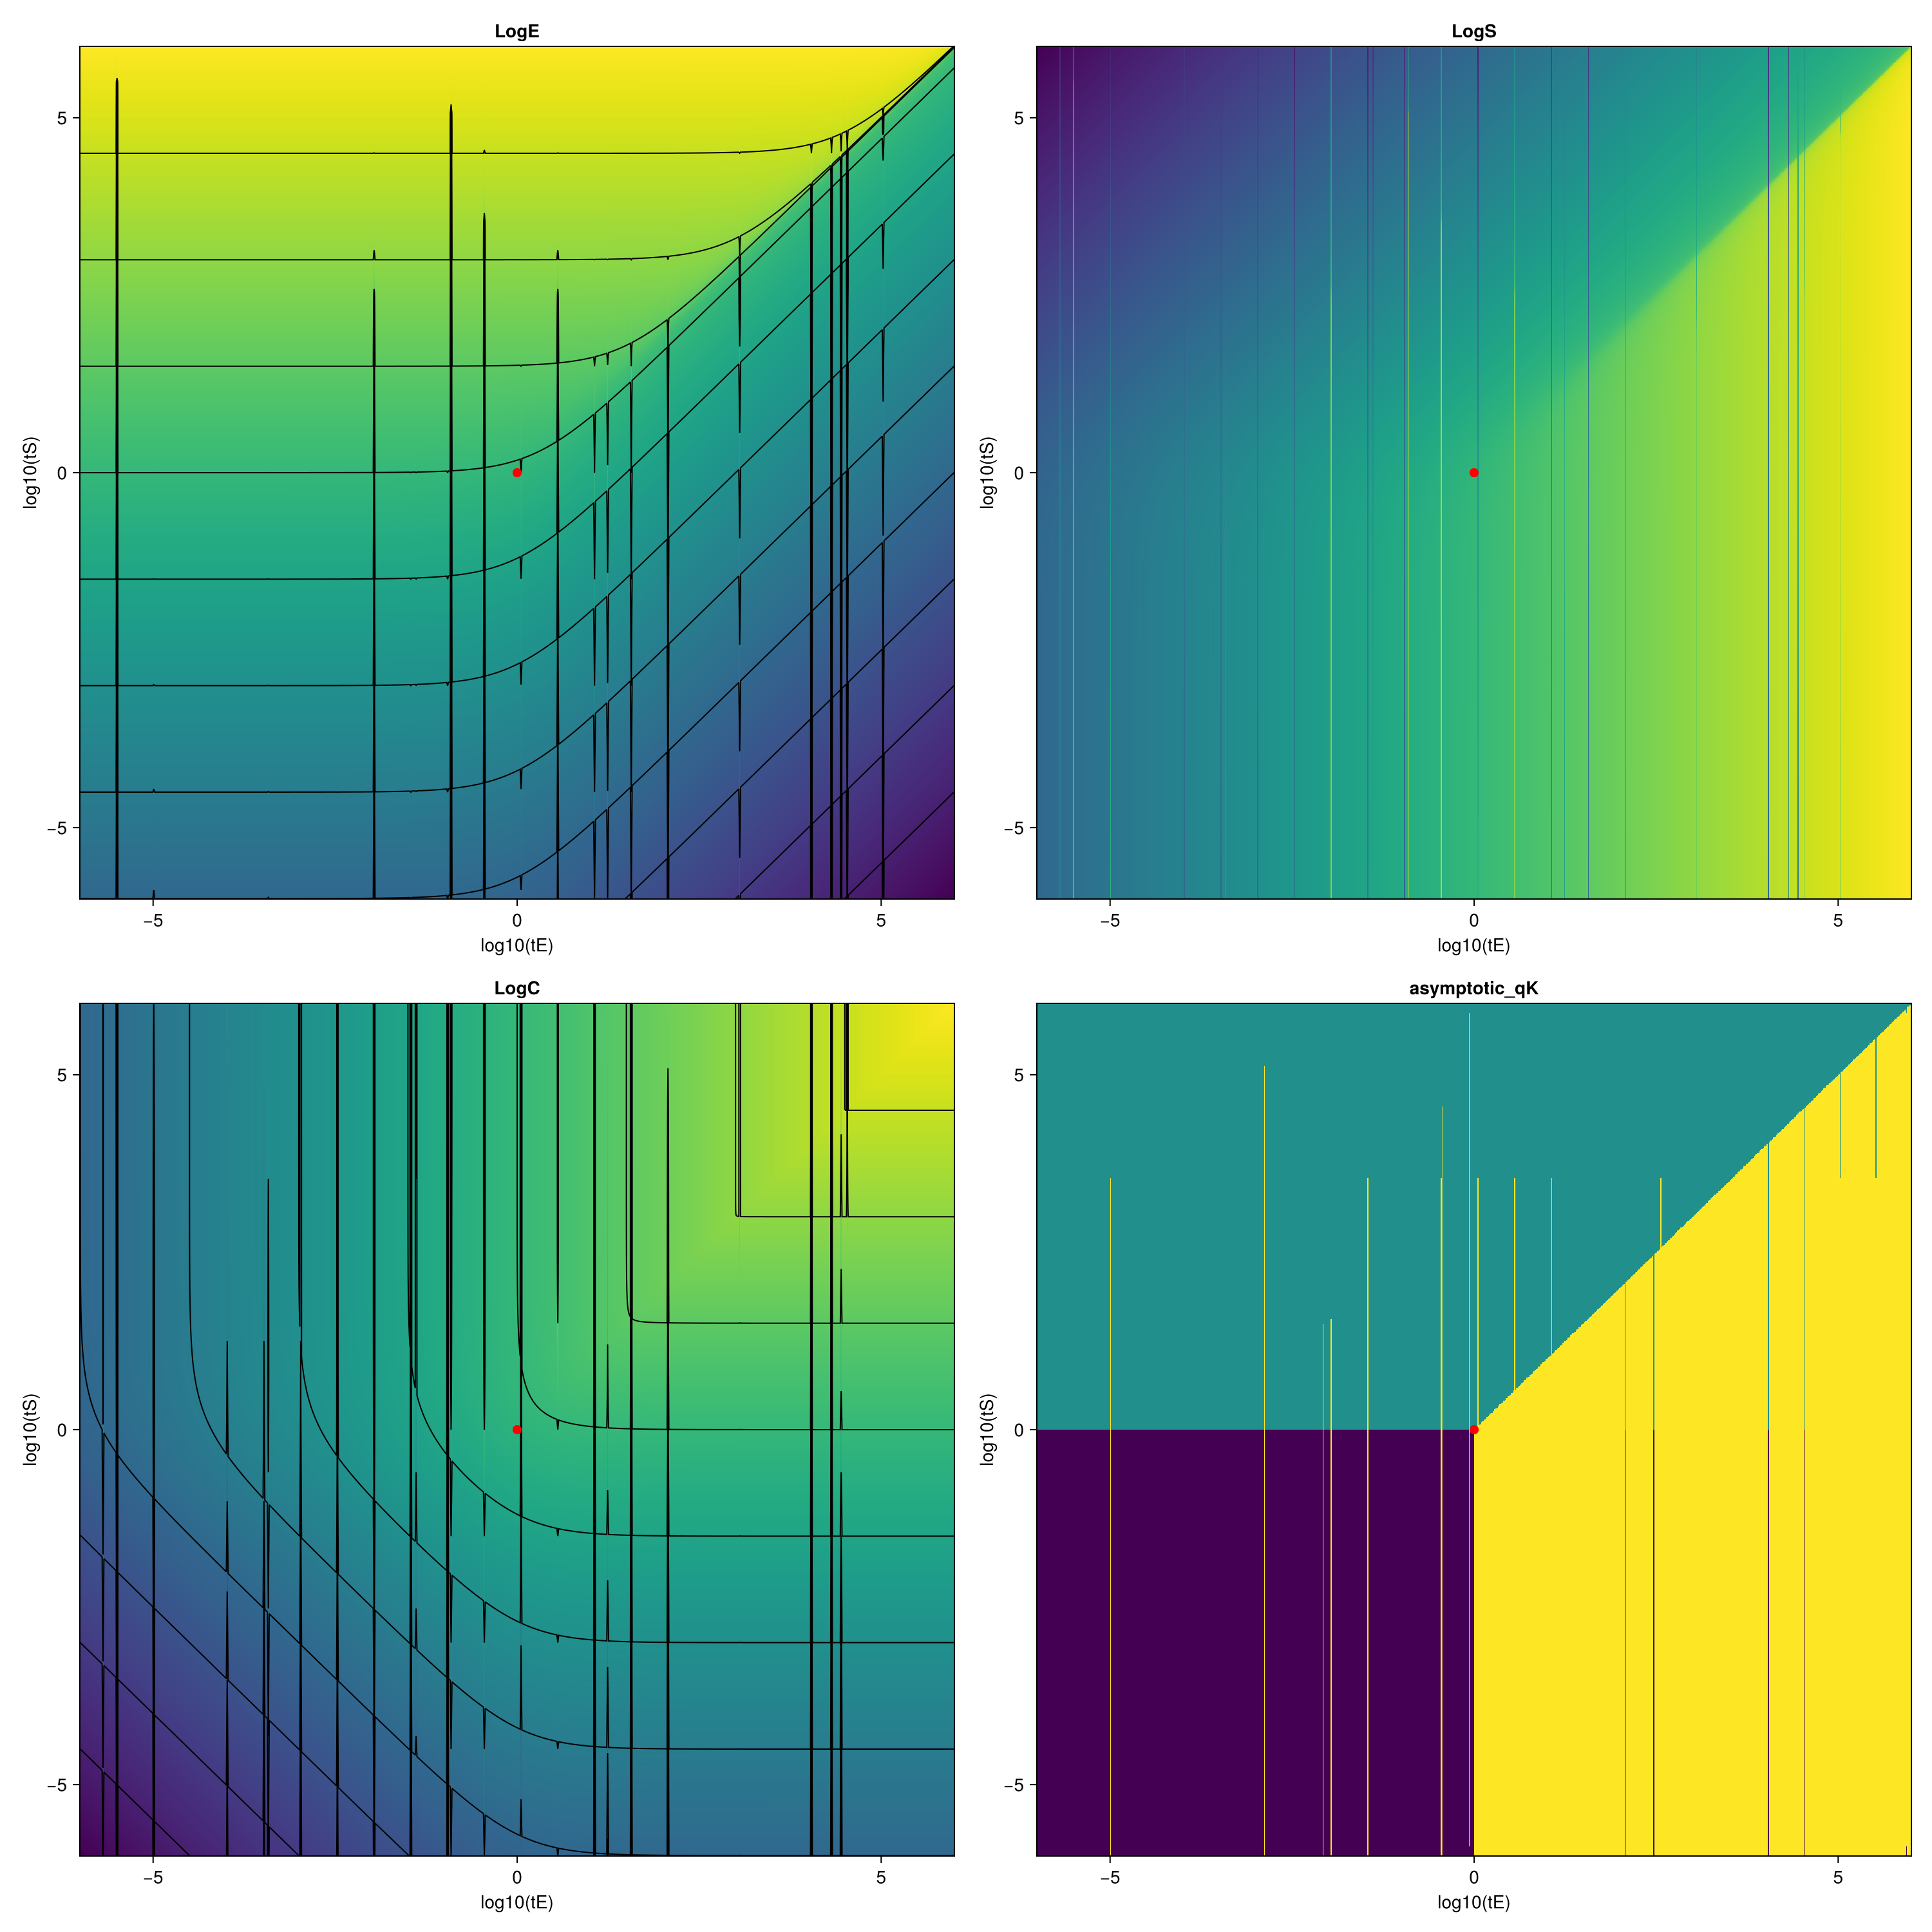

CairoMakie.Screen{IMAGE}


In [21]:
# using GLMakie
f = Figure(size=(1500,1500))
p1 = Axis(f[1, 1])
p2 = Axis(f[1, 2])
p3 = Axis(f[2, 1])
p4 = Axis(f[2, 2])


p1.title = "LogE"
heatmap!(p1, logE_rg, logS_rg, logx .|> x->x[1], colormap=:viridis)
contour!(p1, logE_rg, logS_rg, logx .|> x->x[1], color=:black, levels=-30:1.5:30)
# contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

p2.title = "LogS"
heatmap!(p2, logE_rg, logS_rg, logx .|> x->x[2], colormap=:viridis)


p3.title = "LogC"
heatmap!(p3, logE_rg, logS_rg, logx .|> x->x[3], colormap=:viridis)
contour!(p3, logE_rg, logS_rg, logx .|> x->x[3], color=:black, levels=-30:1.5:30)
# lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)


p4.title = "asymptotic_qK"
heatmap!(p4, logE_rg, logS_rg, col_asym_qK, colormap=:viridis)
# contour!(p4, logE_rg, logS_rg, bnds_asym_qK, color = :black)

for p in [p1, p2, p3, p4]
    # Add the red dot
    scatter!(p, [logK], [logK], marker=:circle, markersize=10, color=:red)
    # Set the axis labels (modern syntax)
    p.xlabel = "log10(tE)"
    p.ylabel = "log10(tS)"
end
# Colorbar(f[:,end+1], colorrange = crange)

display(f)

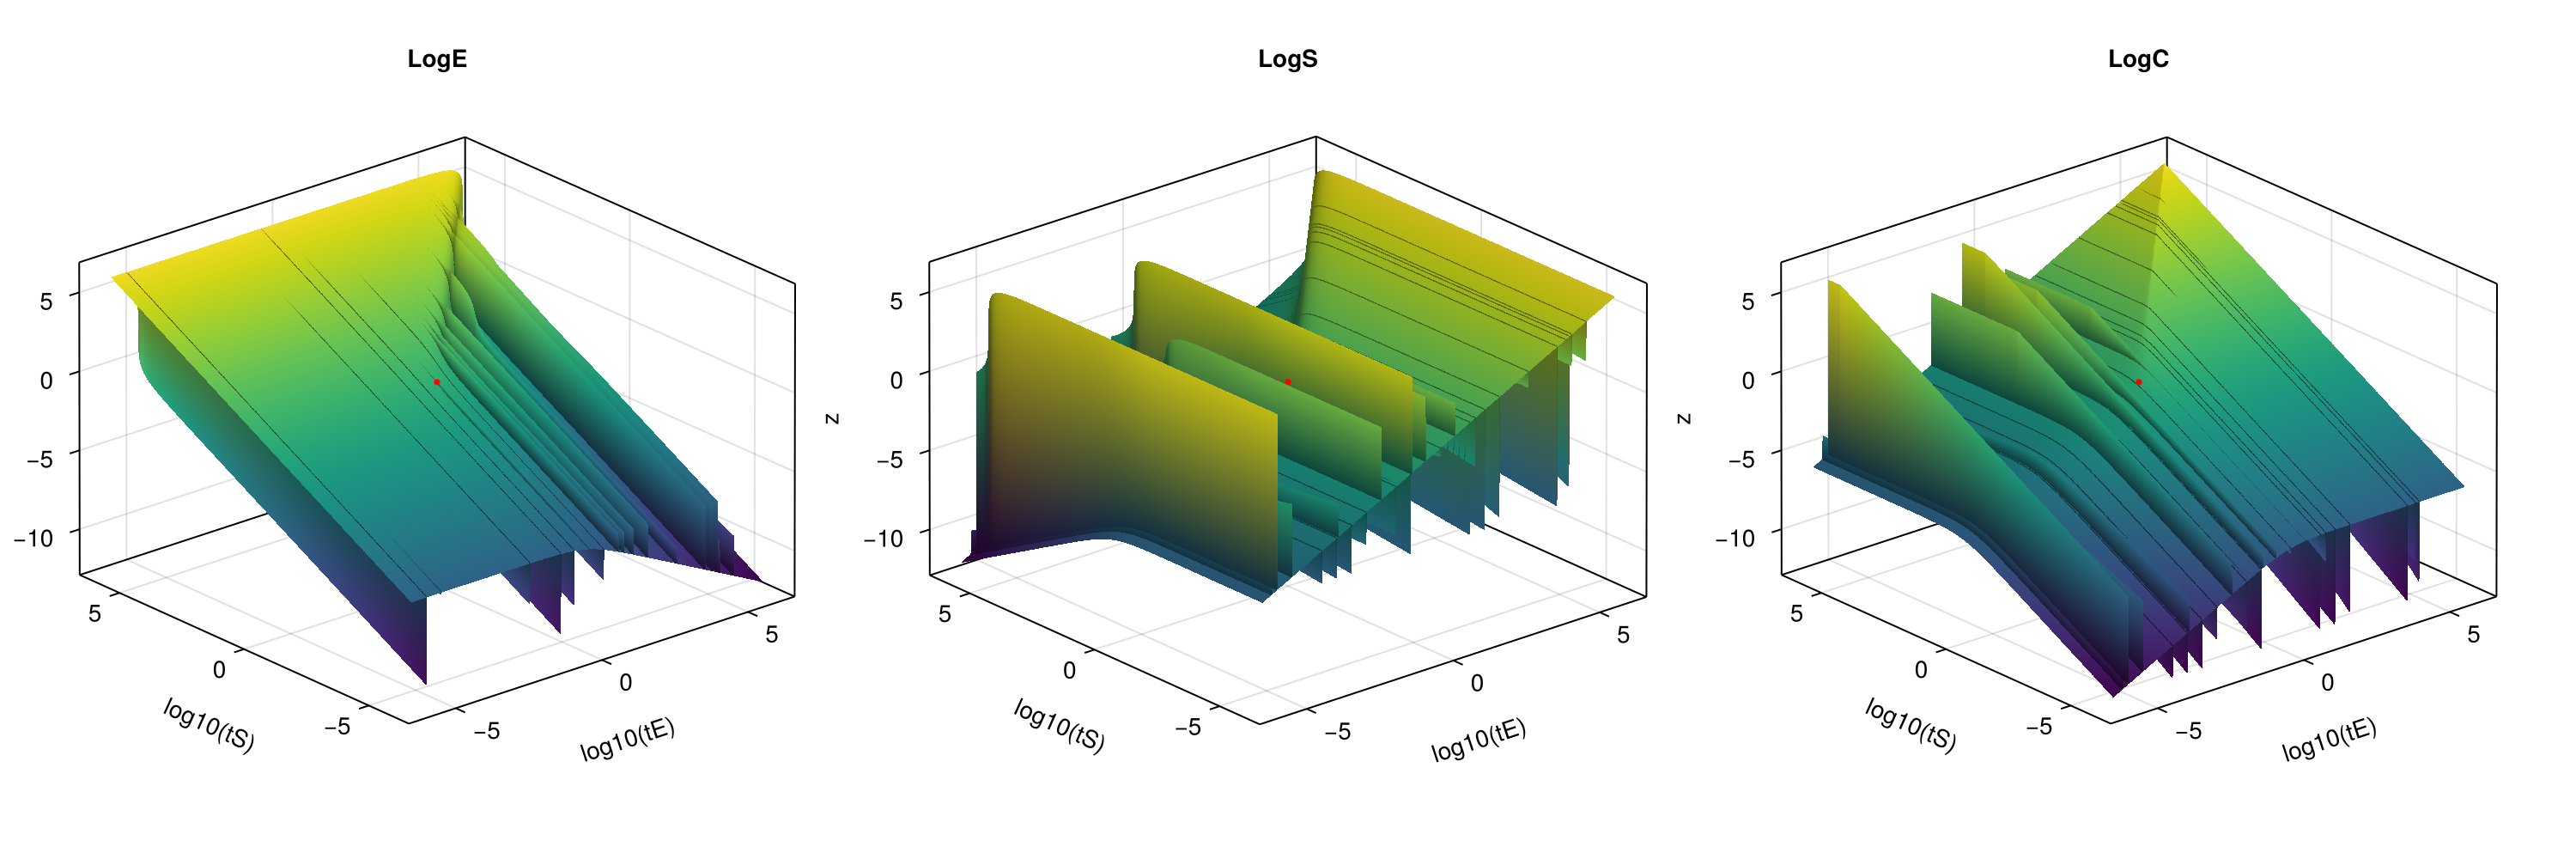

CairoMakie.Screen{IMAGE}


In [22]:
#3D plot
# using GLMakie
f = Figure(size=(1500,500))
p1 = Axis3(f[1, 1])
p2 = Axis3(f[1, 2])
p3 = Axis3(f[1, 3])
# p4 = Axis(f[2, 2])
crange = (-12,6)

p1.title = "LogE"
a1 = surface!(p1, logE_rg, logS_rg, logx .|> x->x[1], colormap=:viridis,colorrange=crange)
# contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

p2.title = "LogS"
surface!(p2, logE_rg, logS_rg, logx .|> x->x[2], colormap=:viridis,colorrange=crange)

p3.title = "LogC"
surface!(p3, logE_rg, logS_rg, logx .|> x->x[3], colormap=:viridis,colorrange=crange)
# contour!(p3, logE_rg, logS_rg, bnds_nonasym_x, color = :black)
# lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)

for p in [p1, p2, p3, ]
    # Add the red dot
    scatter!(p, [logK], [logK],[0], marker=:circle, markersize=5, color=:red)
    # Set the axis labels (modern syntax)
    p.xlabel = "log10(tE)"
    p.ylabel = "log10(tS)"
end
# Colorbar(f[:,end+1], a1)

display(f)

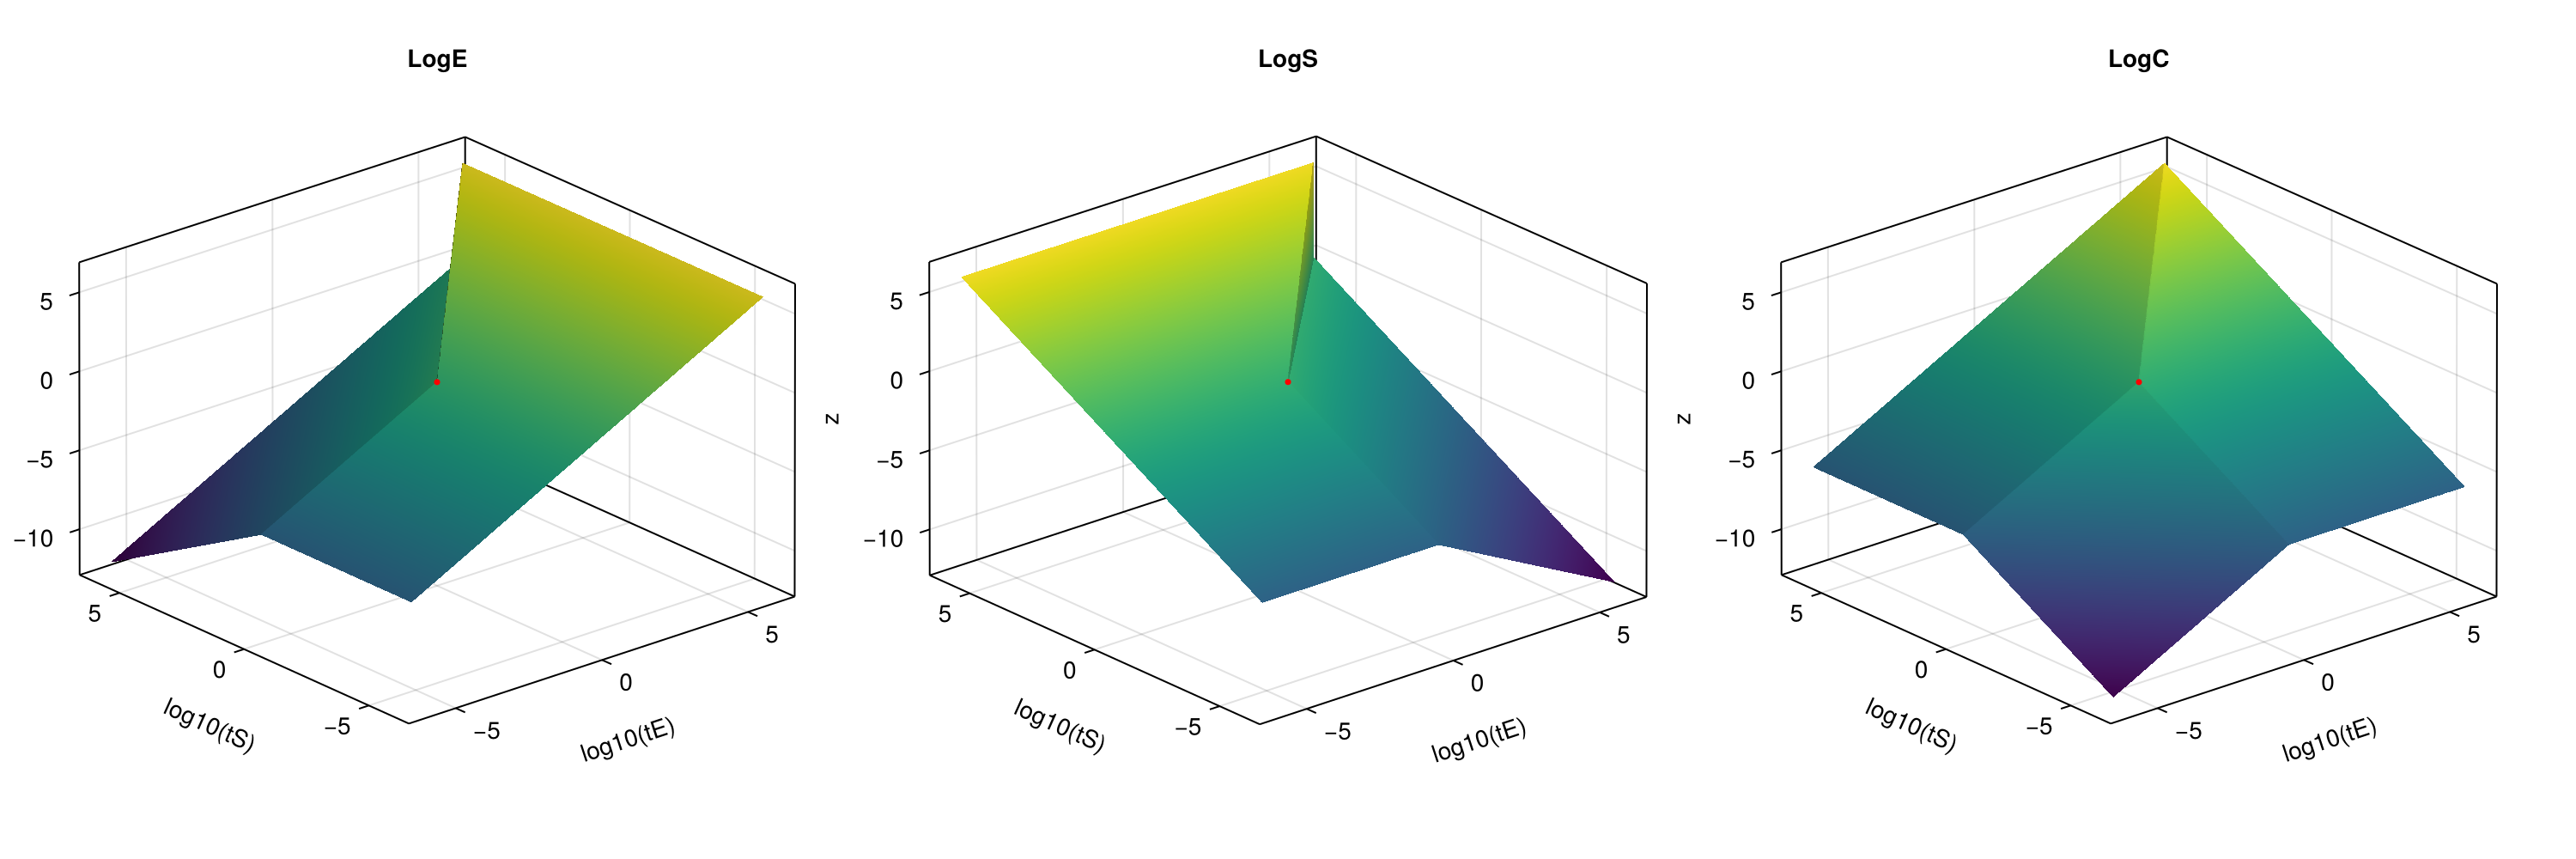

CairoMakie.Screen{IMAGE}


In [11]:
#3D plot
# using GLMakie
f = Figure(size=(1500,500))
p1 = Axis3(f[1, 1])
p2 = Axis3(f[1, 2])
p3 = Axis3(f[1, 3])
# p4 = Axis(f[2, 2])
crange = (-12,6)

p1.title = "LogE"
a1 = surface!(p1, logE_rg, logS_rg, data2 .|> x->x[1], colormap=:viridis,colorrange=crange)
# contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

p2.title = "LogS"
surface!(p2, logE_rg, logS_rg, data2 .|> x->x[2], colormap=:viridis,colorrange=crange)

p3.title = "LogC"
surface!(p3, logE_rg, logS_rg, data2 .|> x->x[3], colormap=:viridis,colorrange=crange)
# contour!(p3, logE_rg, logS_rg, bnds_nonasym_x, color = :black)
# lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)

for p in [p1, p2, p3, ]
    # Add the red dot
    scatter!(p, [log10(K)/c], [log10(K)/c],[0], marker=:circle, markersize=5, color=:red)
    # Set the axis labels (modern syntax)
    p.xlabel = "log10(tE)"
    p.ylabel = "log10(tS)"
end
# Colorbar(f[:,end+1], a1)

display(f)

In [12]:
save("/mnt/d/Documents/minimal_example_plot3D_regimesPOV.png",f, px_per_unit = 4)

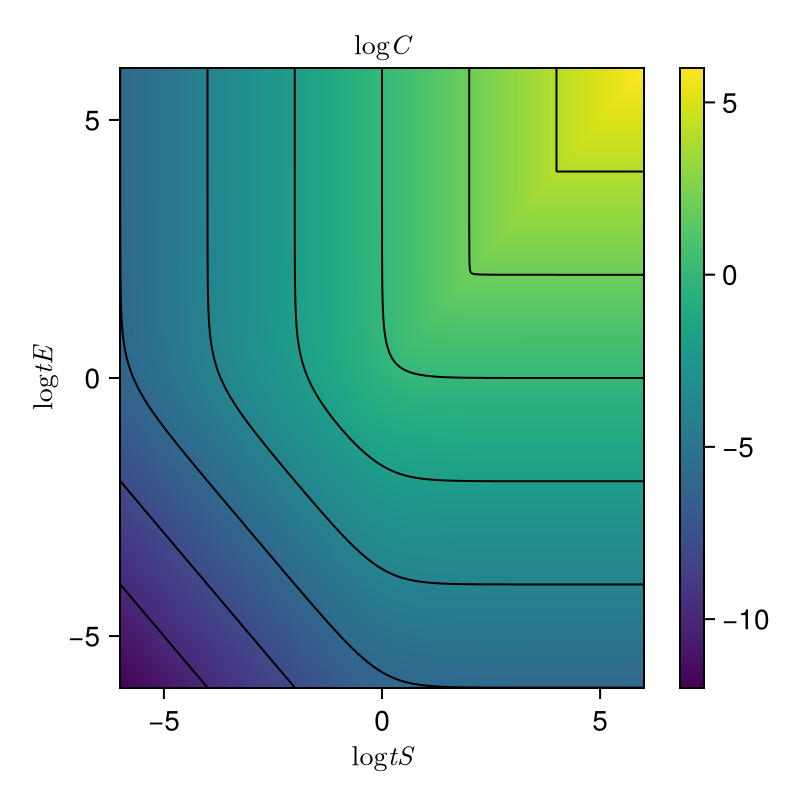

In [ ]:
fig =Figure(size=(400,400),backgroundcolor = :transparent)
ax1 = Axis(fig[1,1],
    ylabel = L"\log tE",
    xlabel = L"\log tS",
    title = L"\log C"
)
hm = heatmap!(ax1, logS_rg, logE_rg, (data .|> x->x[3])' ,colormap=:viridis)
contour!(ax1, logS_rg, logE_rg, (data .|> x->x[3])', color=:black, levels=-30:2:30)
Colorbar(fig[1,2],hm)
display(fig)
# save("/mnt/d/Documents/Direct_solved_logC_countour.png", fig,px_per_unit = 4)

In [13]:
?cgrad

search: cgrad grid deg2rad sprand vgrid! hgrid!



  cgrad(colors, [values]; categorical = nothing, scale = nothing, rev = false, alpha = nothing)

  Construct a Colorgradient from colors and values.

  colors can be a symbol for ColorSchemes.jl ColorSchemes, a ColorScheme, a
  vector of colors, a ColorGradient or a ColorPalette. If values is an
  integer, it specifies the numbers of colors chosen equidistantly from the
  colorscheme specified by colors. Otherwise vectors are accepted. For
  continuous color gradients values indicate where between 0 and 1 the colors
  are positioned. For categorical color gradients values indicate where a
  color ends and where a new one begins between 0 and 1. 0 and 1 are added to
  values if not already present.

  If rev is true colors are reversed. scale accepts the symbols :log, :log10,
  :log2, :ln, :exp, :exp10 or functions. If alpha is set, it is applied to all
  colors.

In [16]:
my_cmap

3-element Vector{ColorSchemes.ColorScheme{Vector{ColorTypes.RGBA{Float64}}, String, String}}:
 ColorSchemes.ColorScheme{Vector{ColorTypes.RGBA{Float64}}, String, String}(ColorTypes.RGBA{Float64}[RGBA(0.05, 0.05, 0.05, 1.0), RGBA(0.06836734693877554, 0.06836734693877554, 0.06836734693877554, 1.0), RGBA(0.08673469387755106, 0.08673469387755106, 0.08673469387755106, 1.0), RGBA(0.1051020408163266, 0.1051020408163266, 0.1051020408163266, 1.0), RGBA(0.12346938775510212, 0.12346938775510212, 0.12346938775510212, 1.0), RGBA(0.14183673469387745, 0.14183673469387745, 0.14183673469387745, 1.0), RGBA(0.16020408163265298, 0.16020408163265298, 0.16020408163265298, 1.0), RGBA(0.17857142857142852, 0.17857142857142852, 0.17857142857142852, 1.0), RGBA(0.19693877551020403, 0.19693877551020403, 0.19693877551020403, 1.0), RGBA(0.21530612244897956, 0.21530612244897956, 0.21530612244897956, 1.0)  …  RGBA(0.7846938775510204, 0.7846938775510204, 0.7846938775510204, 1.0), RGBA(0.8030612244897959, 0.803061224489

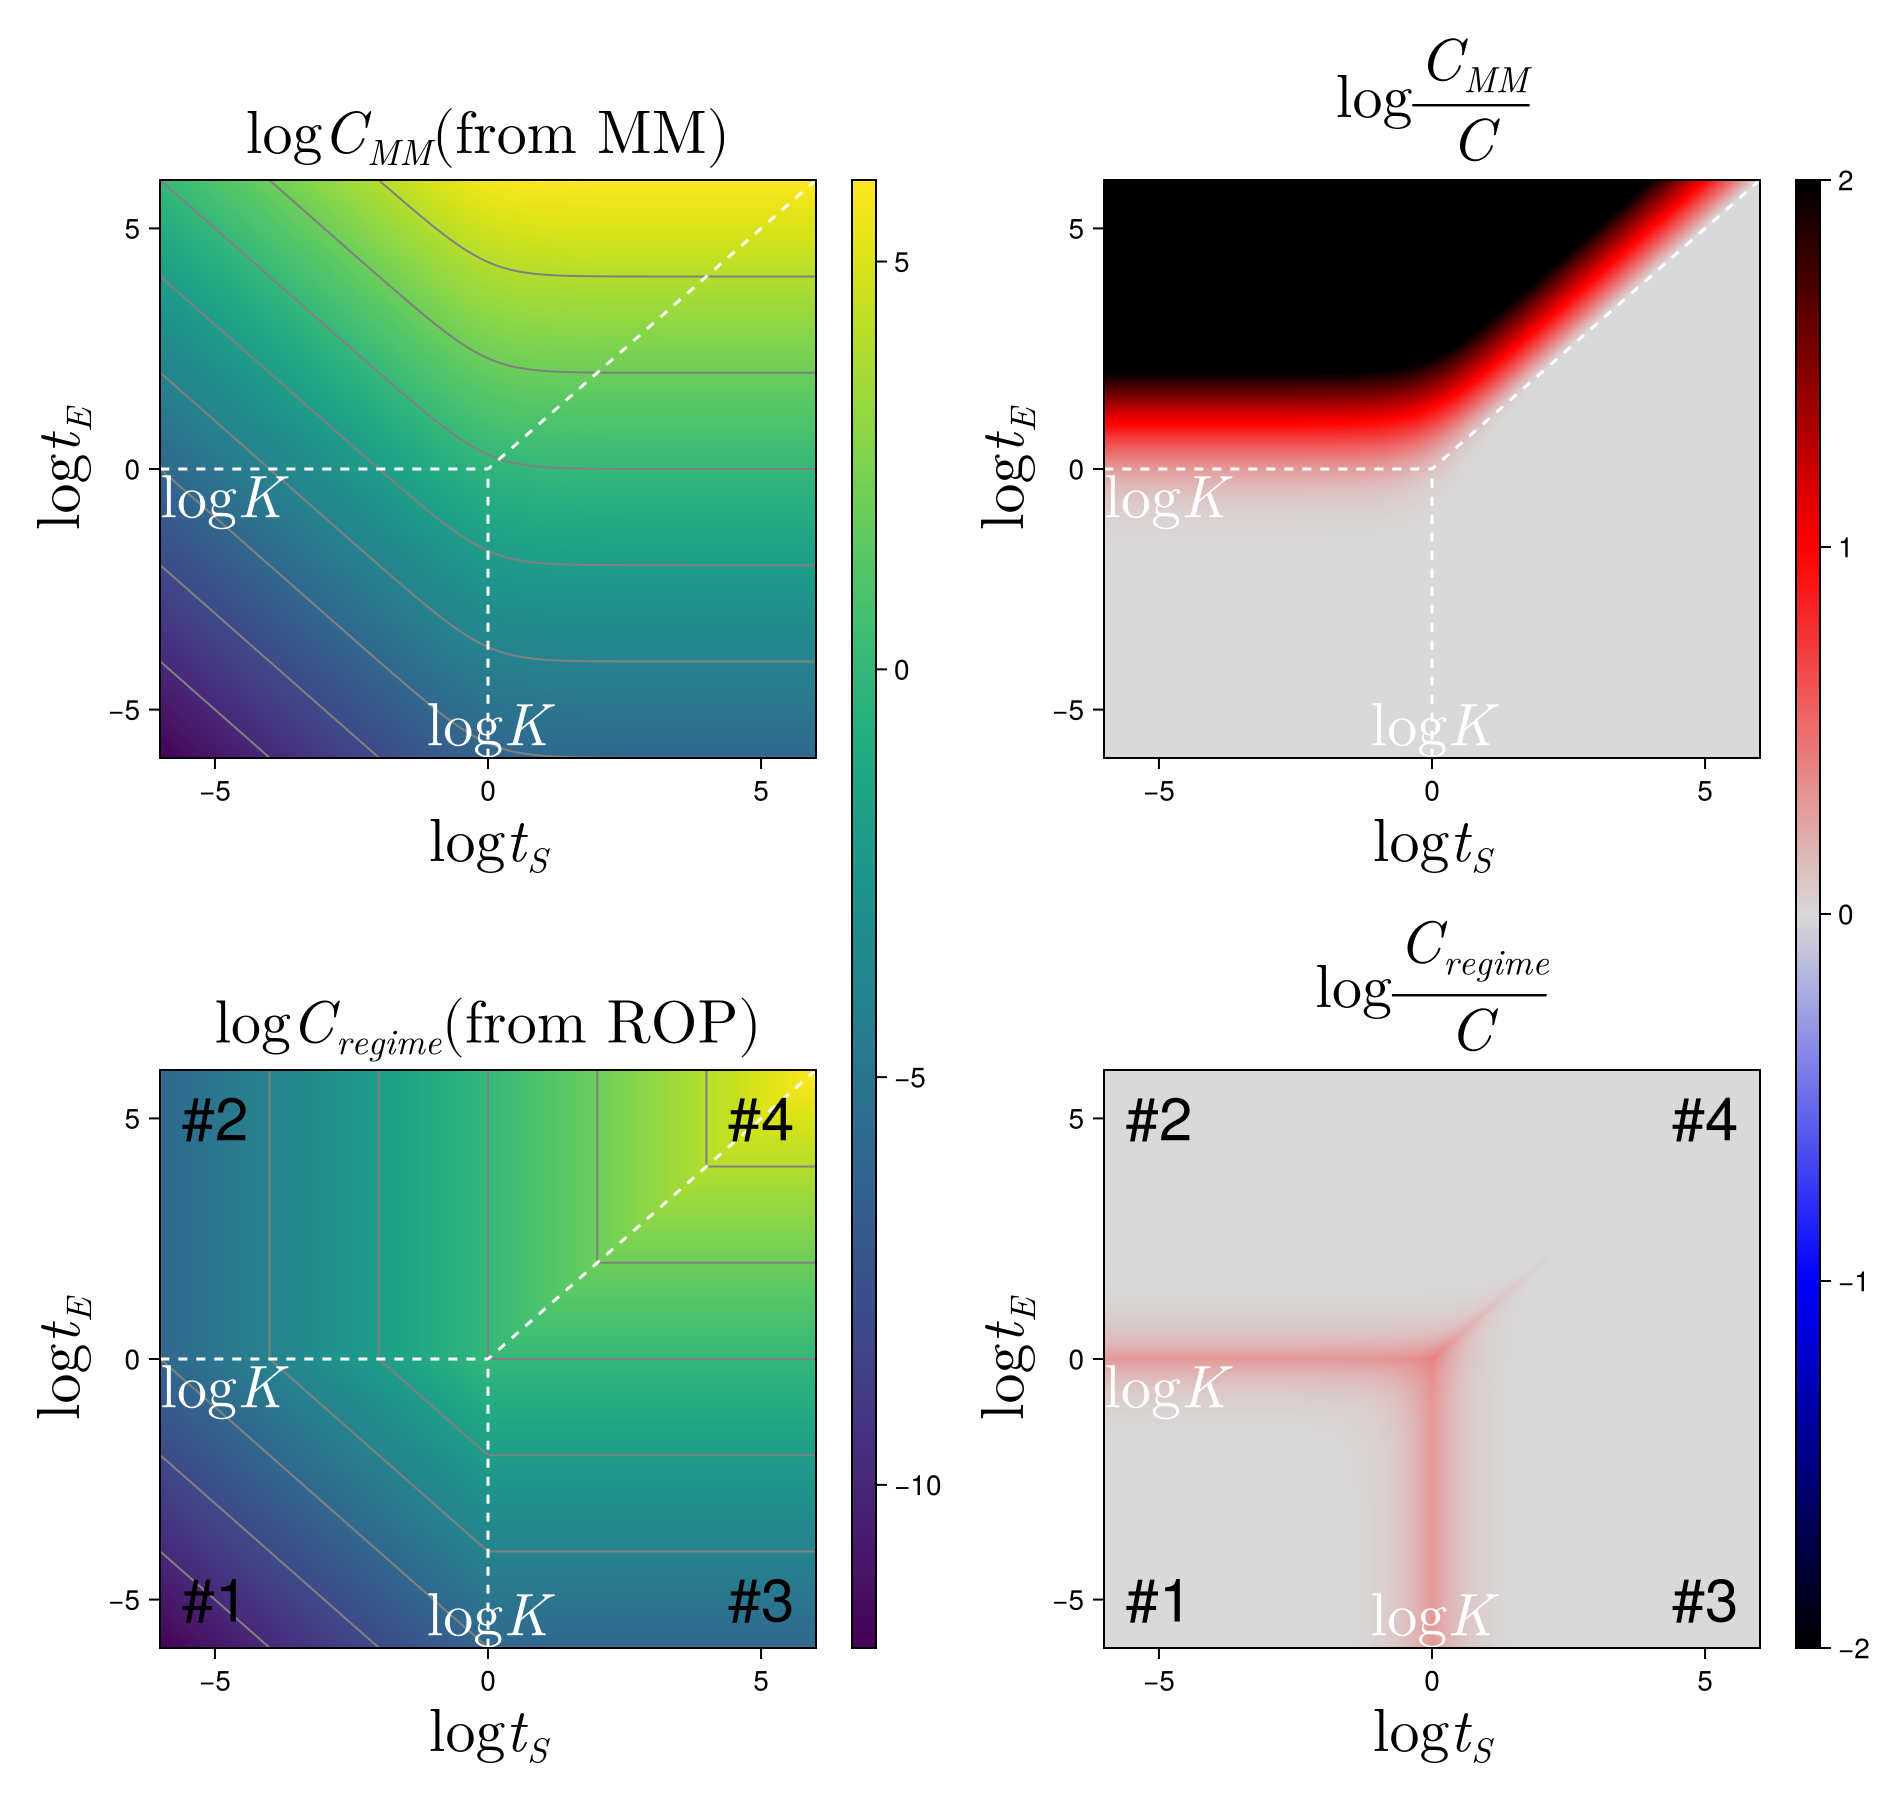

In [ ]:
line1 = Point2d.([[-6,0],[0,0]])
line2 = Point2d.([[0,-6],[0,0]])
line3 = Point2d.([[6,6],[0,0]])
txtsize = 30

add_line(ax) = begin
    for line in (line1, line2, line3)
        lines!(ax, line, color=:white, linestyle=:dash)
    end
end
add_text(ax) = begin
    text!(ax,Point(0,-6); text =  L"\log K",  align = (:center, :bottom), color=:white, rotation = 0, fontsize = txtsize)
    text!(ax,Point(-6,0); text =  L"\log K",  align = (:left, :top), color=:white, rotation = 0, fontsize = txtsize)
end
add_regime(ax) = begin
    text!(ax,Point(-5,-5); text =  "#1",  align = (:center, :center), color=:black, rotation = 0, fontsize = txtsize)
    text!(ax,Point(-5,5); text =  "#2",  align = (:center, :center), color=:black, rotation = 0, fontsize = txtsize)
    text!(ax,Point(5,-5); text =  "#3",  align = (:center, :center), color=:black, rotation = 0, fontsize = txtsize)
    text!(ax,Point(5,5); text =  "#4",  align = (:center, :center), color=:black, rotation = 0, fontsize = txtsize)
end

begin
    neg = cgrad([:blue,:black], 100; rev=true).colors.colors
    mid = cgrad([:blue,"#D9D9D9",:red], 200).colors.colors
    pos = cgrad([:red,:black], 100).colors.colors
    my_cmap = vcat(neg, mid, pos)
end

fig =Figure(size=(950,900),backgroundcolor = :transparent)

ax1 = Axis(fig[1,1],
    # aspect = AxisAspect(1),
    ylabel = L"\log t_E",
    xlabel = L"\log t_S",
    title = L"\log C_{MM}(\text{from MM})",
    titlesize = txtsize,
    xlabelsize = txtsize,
    ylabelsize = txtsize
)
min_val, max_val = extrema(MM_data)
hm = heatmap!(ax1, logS_rg, logE_rg, MM_data' ,colormap=:viridis, colorrange = (min_val, max_val))
contour!(ax1, logS_rg, logE_rg, MM_data', color=:gray, levels=-30:2:30)
add_line(ax1)
add_text(ax1)
# add_regime(ax1)

# ax2 = Axis(fig[1:2,1],
#     aspect = AxisAspect(1),
#     ylabel = L"\log qE",
#     xlabel = L"\log qS",
#     title = L"\log C(directly solved)"
# )
# heatmap!(ax2, logS_rg, logE_rg, (data .|> x->x[3])' ,colormap=:viridis, colorrange = (min_val, max_val))
# contour!(ax2, logS_rg, logE_rg, (data .|> x->x[3])', color=:gray, levels=-30:2:30)
# add_line(ax2)
# add_text(ax2)
# add_regime(ax2)

ax3 = Axis(fig[2,1],
    # aspect = AxisAspect(1),
    ylabel = L"\log t_E",
    xlabel = L"\log t_S",
    title = L"\log C_{regime}(\text{from ROP})",
    titlesize = txtsize,
    xlabelsize = txtsize,
    ylabelsize = txtsize
)
heatmap!(ax3, logS_rg, logE_rg, (data2 .|> x->x[3])' ,colormap=:viridis, colorrange = (min_val, max_val))
contour!(ax3, logS_rg, logE_rg, (data2 .|> x->x[3])', color=:gray, levels=-30:2:30)
add_line(ax3)
add_text(ax3)
add_regime(ax3)


Colorbar(fig[1:2,2],hm)

ax3 = Axis(fig[1,3],
    # aspect = AxisAspect(1),
    ylabel = L"\log t_E",
    xlabel = L"\log t_S",
    title = L" \log \frac{C_{MM}}{C}",
    titlesize = txtsize,
    xlabelsize = txtsize,
    ylabelsize = txtsize
)
diff_data = MM_data .- (data .|> x->x[3])
max_diff = maximum(abs.(diff_data))
max_diff = 2
hm2 = heatmap!(ax3, logS_rg, logE_rg, diff_data' ,colormap=my_cmap,colorrange = (-max_diff, max_diff))
# contour!(ax3, logS_rg, logE_rg, diff_data',color=:gray)
add_line(ax3)
add_text(ax3)
# add_regime(ax3)


ax4 = Axis(fig[2,3],
    # aspect = AxisAspect(1),
    ylabel = L"\log t_E",
    xlabel = L"\log t_S",
    title = L" \log \frac{C_{regime}}{C}",
    titlesize = txtsize,
    xlabelsize = txtsize,
    ylabelsize = txtsize
)
diff_data = (data2 .- data) .|> x->x[3]
# max_diff = maximum(abs.(diff_data))
hm2 = heatmap!(ax4, logS_rg, logE_rg, diff_data' ,colormap=my_cmap,colorrange = (-max_diff, max_diff))
# contour!(ax4, logS_rg, logE_rg, diff_data',color=:gray)
# add_line(ax4)
add_text(ax4)
add_regime(ax4)

Colorbar(fig[1:2,4],colormap=my_cmap,colorrange = (-max_diff, max_diff))


display(fig)
# save("/home/joker/paper_writing/PAPER_WORK/ifac2026_R_idx/figures/MM_vs_ROP_vs_Direct2.png", fig, px_per_unit = 6)
save("/mnt/e/Pictures/MM_vs_ROP_vs_Direct2.png", fig, px_per_unit = 6)
# save("/home/joker/paper_writing/PAPER_WORK/ifac2026_R_idx/figures/MM_vs_directly_solved.png", fig, px_per_unit = 6)
# save("/home/joker/paper_writing/PAPER_WORK/ifac2026_R_idx/figures/MM_vs_ROP_vs_Direct.png", fig, px_per_unit = 6)

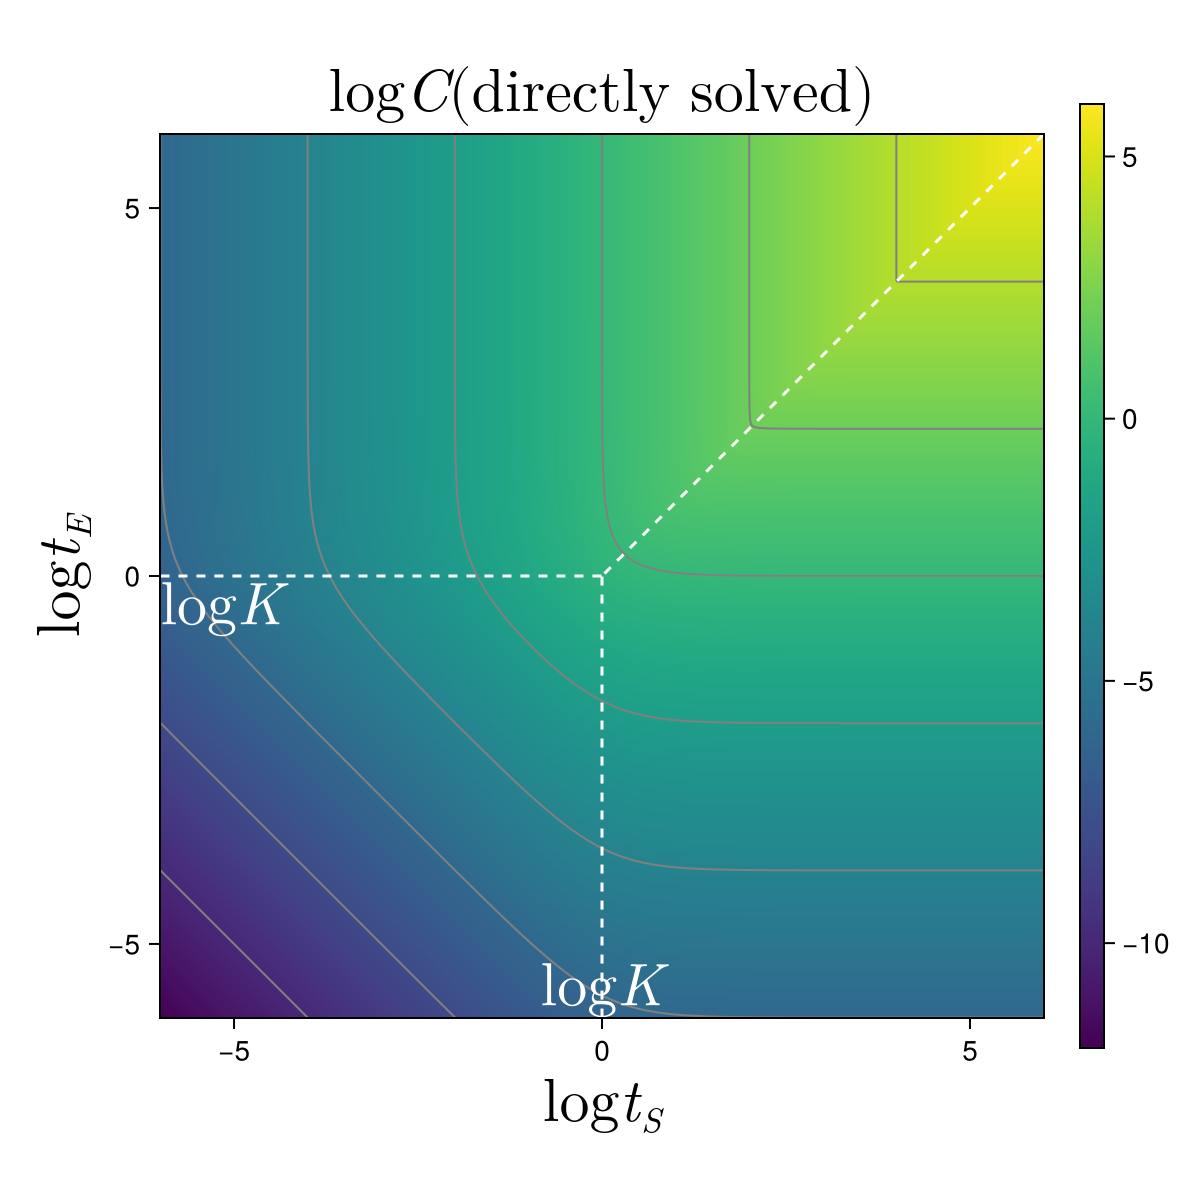

In [78]:
fig =Figure(size=(600,600),backgroundcolor = :transparent)
ax2 = Axis(fig[1,1],
    aspect = AxisAspect(1),
    ylabel = L"\log t_E",
    xlabel = L"\log t_S",
    title = L"\log C(\text{directly solved})",
    titlesize = txtsize,
    xlabelsize = txtsize,
    ylabelsize = txtsize
)
hm = heatmap!(ax2, logS_rg, logE_rg, (data .|> x->x[3])' ,colormap=:viridis, colorrange = (min_val, max_val))
contour!(ax2, logS_rg, logE_rg, (data .|> x->x[3])', color=:gray, levels=-30:2:30)
Colorbar(fig[1,2],hm)
add_line(ax2)
add_text(ax2)
# add_regime(ax2)
display(fig)

save("/mnt/e/Pictures/C_Direct.png", fig, px_per_unit = 6)

In [24]:
typeof(my_cmap[1]) |> fieldnames

(:colors, :category, :notes)

In [28]:
neg = cgrad(:grays, 50).colors.colors |> typeof

Vector{RGBA{Float64}} (alias for Array{ColorTypes.RGBA{Float64}, 1})

In [26]:
maximum(diff_data)

0.41529673554044283

In [27]:
maximum(abs.(diff_data))

0.41529673554044283